In [1]:
#Import modules and declare TIC

%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import lightkurve as lk
from scipy.interpolate import make_interp_spline as spline
import scipy.signal as signal
import matplotlib
import plotly.express as px
from astropy.time.core import Time
from modules import *

plt.style.use('seaborn-v0_8-darkgrid')

TIC = 'TIC 219107776'

In [2]:
#Download the data and stitch it together

search_results = lk.search_lightcurve(TIC, cadence='short', author='SPOC')

#Enter the data index to be used                                                                                        [INPUT NEEDED]
use_till = 5

lcs = []
for i in range(use_till):
    try:
        lcs.append(search_results[i].download(quality_bitmask='hardest'))
    except:
        pass

search_results


#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 14,2019,SPOC,120,219107776,0.0
1,TESS Sector 15,2019,SPOC,120,219107776,0.0
2,TESS Sector 16,2019,SPOC,120,219107776,0.0
3,TESS Sector 17,2019,SPOC,120,219107776,0.0
4,TESS Sector 18,2019,SPOC,120,219107776,0.0
5,TESS Sector 20,2019,SPOC,120,219107776,0.0
6,TESS Sector 26,2020,SPOC,120,219107776,0.0
7,TESS Sector 24,2020,SPOC,120,219107776,0.0
8,TESS Sector 21,2020,SPOC,120,219107776,0.0


In [3]:
straight_lines(lcs[0]).plot()
lcs[0].plot()
print(lcs[0].flux.unit)

[9239]


ValueError: length of new column must match table length

In [118]:
flux = np.array(lcs[0].flux, dtype=float)
time = np.array(lcs[0].time.jd)

flux = np.append(flux, np.array(lcs[1].flux, dtype=float))
time = np.append(time, np.array(lcs[1].time.jd))

cadence_in_days = ((np.median(np.diff(time[:100])) * 86400).round())/86400

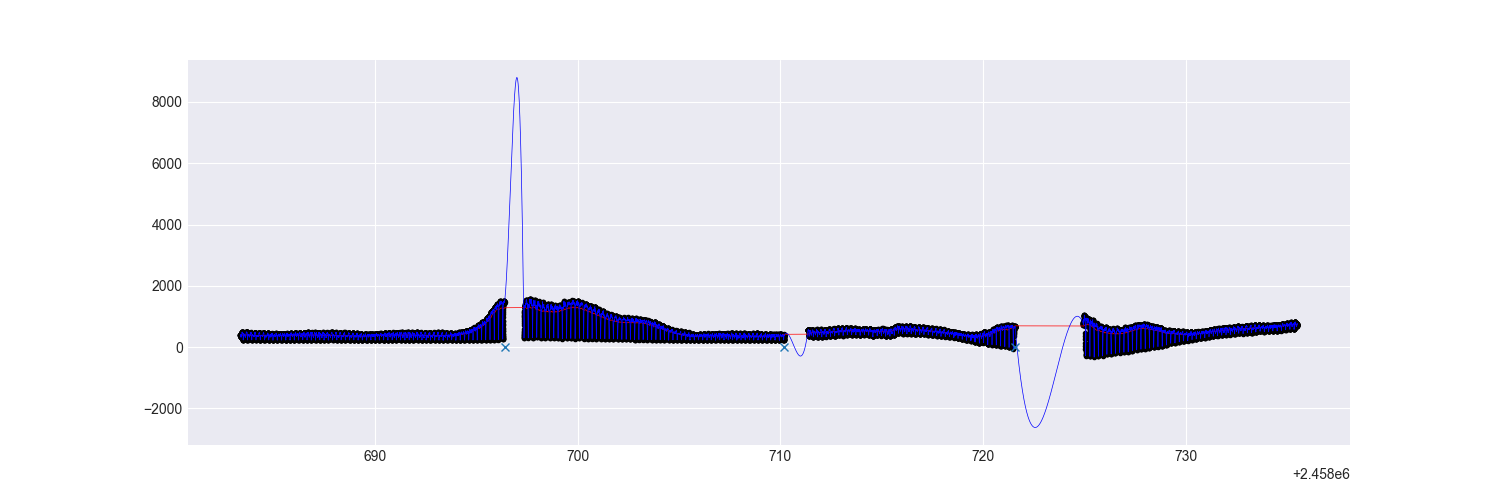

In [120]:
plt.figure(figsize = (15, 5))
plt.plot(time, flux, 'k.', lw = 0.5)
plt.plot(time, signal.savgol_filter(flux, 1000, 4), 'r', lw = 0.5)
plt.plot(time_smooth, flux_smooth, 'b', lw = 0.5)
plt.plot(peaktimes, range(len(peaktimes)), 'x')
plt.show()

In [ ]:
time_smooth = np.linspace(time.min(), time.max(), len(time) * 8)
flux_smooth = spline(time, flux, k = 3)(time_smooth)

In [122]:
l = lk.LightCurve(time = time, flux = flux)

In [129]:
def straight_lines(lightcurve : lk.lightcurve.LightCurve):

    #BASICS
    flux = np.array(lightcurve.flux, dtype=float)
    time = np.array(lightcurve.time.jd)
    cadence_in_days = ((np.median(np.diff(time[:100])) * 86400).round())/86400
    lc = pd.DataFrame({'time': time, 'flux': flux})

    #PEAKS
    peaks, _ = signal.find_peaks(np.diff(time), height = cadence_in_days * 10)
    print(peaks)

    #Filling the Gaps
    for i in peaks:
        t = (time[i], time[i+1])
        f = (flux[i], flux[i+1])
        df = pd.DataFrame({'time': t, 'flux': f})
        df.set_index('time', inplace = True)
        df = df.reindex(np.arange(time[i], time[i+1], cadence_in_days))
        df['flux'] = df['flux'].interpolate('linear')
        df.reset_index(inplace = True)
        df.rename(columns={'index':'time'}, inplace=True)
        lc = pd.concat([df[1:-1], lc]).sort_values('time')

    time_final = np.array(lc['time'])
    flux_final = np.array(lc['flux'])
    time_smooth = np.linspace(time_final.min(), time_final.max(), len(time_final) * 4)
    flux_smooth = spline(time_final, flux_final, k = 3)(time_smooth)

    return pd.DataFrame({'time': time_smooth, 'flux': flux_smooth})



[9239]


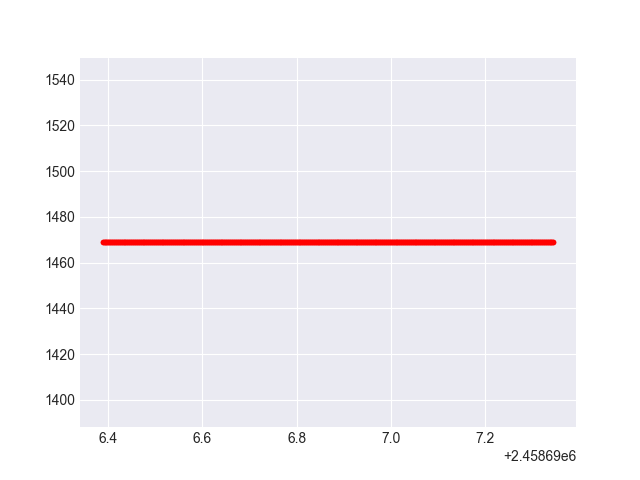

In [ ]:
px.line(x = time, y = signal.savgol_filter(flux, 101, 3)).show()